## Simple transportation problem example

We have set of customers I = [1,2,3,4,5] and set of factories J = [1,2,3].
Each customer has some fixed product demand d_i and each factory has fixed production capacity M_j. There are also fixed transportation costs to deliver one unit of good from factory j to customer i.

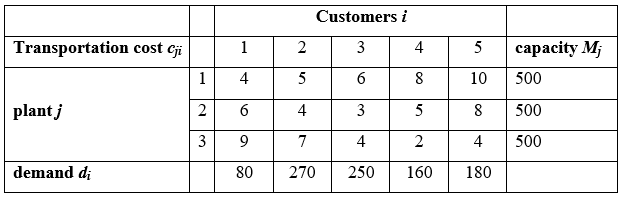

Our task is to deliver necessary amount of goods to each customer (satisfy customer demand and factories production capacity) at minimal total transportation cost. To formulate this situation as optimization problem we must separate it into 3 main components:

- decision variables — quantities of goods to be sent from factory j to customer i (positive real numbers)
- constraints — total amount of goods must satisfy both customer demand and factory production capacity (equalities/inequalities that have linear expression on the left-hand side)
- objective function — find such values of decision variables that total transportation cost is the lowest (linear expression in this case)

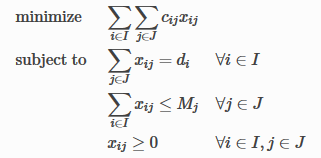

In [ ]:
# Data Structures in Python

d = {1:80, 2:270, 3:250, 4:160, 5:180}  # customer demand
M = {1:500, 2:500, 3:500}               # factory capacity
I = [1,2,3,4,5]                         # Customers
J = [1,2,3]                             # Factories
cost = {(1,1):4, (1,2):6, (1,3):9, (2,1):5, (2,2):4, (2,3):7,
        (3,1):6, (3,2):3, (3,3):3, (4,1):8, (4,2):5, (4,3):3,
        (5,1):10,(5,2):8, (5,3):4 }     # transportation costs

### Solution with SciPy

In [ ]:
# Import necessary libraries
import sys
import numpy as np
from scipy.optimize import minimize

In [ ]:
# to be used in SciPy we must transform cost dictionary into 2D aray
cost2d = np.empty([len(I), len(J)])
for i in range(len(I)):
    for j in range(len(J)):
        cost2d[i,j] = cost[i+1,j+1]

In [ ]:
cost2d

array([[ 4.,  6.,  9.],
       [ 5.,  4.,  7.],
       [ 6.,  3.,  3.],
       [ 8.,  5.,  3.],
       [10.,  8.,  4.]])

In [ ]:
# Initialize Decision Variables
x0 = np.ones(len(cost))*100
bounds = list((0,max(d.values())) for _ in range(cost2d.size))

In [ ]:
# Declare Ojective Function
def objective(x):
    obj_func = sum(x[idx]*cost2d[idx//len(J), idx%len(J)] for idx in range(cost2d.size))
    return obj_func

In [ ]:
# Define Constraints:
# sum of goods == customer demand
def const1():
    tmp = []
    for idx in range(0, cost2d.size, len(J)):
        tmp_constr = {
            'type': 'eq',
            'fun': lambda x, idx: d[idx//len(J) + 1] - np.sum(x[idx: idx + len(J)]),
            'args': (idx,)
            }
        tmp.append(tmp_constr)
    return tmp
# Constraints: sum of goods <= factory capacity
def const2():
    tmp = []
    for idx in range(0, cost2d.size, len(I)):
        tmp_constr = {
            'type': 'ineq',
            'fun': lambda x, idx=idx: M[idx//len(I) + 1] - np.sum(x[idx: idx + len(I)])
            }
        tmp.append(tmp_constr)
    return tmp
list_of_lists = [const1(), const2()]
constraints = [item for sublist in list_of_lists for item in sublist]

In [ ]:
# Solve the optimization problem
solution = minimize(fun = objective,
                x0 = x0,
                bounds = bounds,
                method = 'SLSQP',
                constraints = constraints,
                tol = None,
                callback = None,
                options = {'full_output':False, 'disp':False, 'xtol': 1e-8}
                )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: OptimizeWarning: Unknown solver options: full_output, xtol
  if __name__ == '__main__':


In [ ]:
# Check the Results
if (solution.success) and (solution.status == 0):
    print("Solution is feasible and optimal")
    print("Objective function value = ", round(solution.fun,2))
elif solution.status != 0:
    print("Failed to find solution. Exit code", solution.status)
else:
    # something else is wrong
    print(solution.message)
if solution.success:
    EPS = 1.e-6
    for i,_ in enumerate(solution.x):
        if solution.x[i] > EPS:
            print("sending quantity %4s from factory %2s to customer %2s" % (round(solution.x[i]), i%len(J) + 1, i//len(J) + 1))

Solution is feasible and optimal
Objective function value =  3350.0
sending quantity   80 from factory  1 to customer  1
sending quantity  270 from factory  2 to customer  2
sending quantity  125 from factory  2 to customer  3
sending quantity  125 from factory  3 to customer  3
sending quantity  160 from factory  3 to customer  4
sending quantity  180 from factory  3 to customer  5


### Solution with Pyomo

In [ ]:
# Import necessary libraries
# !pip install glpk
!pip install pyomo
!sudo apt-get install glpk-utils
from pyomo import environ as pe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
glpk-utils is already the newest version (4.65-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [ ]:
# ConcreteModel is model where data values supplied at the time of the model definition.
# As opposite to AbstractModel where data values are supplied in data file
model = pe.ConcreteModel()

# all iterables are to be converted into Set objects
model.d_cust_demand = pe.Set(initialize = d.keys())
model.M_fact_capacity = pe.Set(initialize = M.keys())

# Parameters
# Cartesian product of two sets creates list of tuples [((i1,j1),v1),((i2,j2),v2),...] !!!
model.transport_cost = pe.Param(
    model.d_cust_demand * model.M_fact_capacity,
    initialize = cost,
    within = pe.NonNegativeReals)
model.cust_demand = pe.Param(model.d_cust_demand, 
    initialize = d,
    within = pe.NonNegativeReals)
model.fact_capacity = pe.Param(model.M_fact_capacity, 
    initialize = M,
    within = pe.NonNegativeReals)

In [ ]:
# Initialize Decision Variables
model.x = pe.Var(
    model.d_cust_demand * model.M_fact_capacity,
    domain = pe.NonNegativeReals,
    bounds = (0, max(d.values())))

In [ ]:
# Declare Ojective Function
model.objective = pe.Objective(
    expr = pe.summation(model.transport_cost, model.x),
    sense = pe.minimize)

In [ ]:
# Define Constraints:
# sum of goods == customer demand
def meet_demand(model, customer):
    sum_of_goods_from_factories = sum(model.x[customer,factory] for factory in model.M_fact_capacity)
    customer_demand = model.cust_demand[customer]
    return sum_of_goods_from_factories == customer_demand
model.Constraint1 = pe.Constraint(model.d_cust_demand, rule = meet_demand)
# Constraints: sum of goods <= factory capacity
def meet_capacity(model, factory):
    sum_of_goods_for_customers = sum(model.x[customer,factory] for customer in model.d_cust_demand)
    factory_capacity = model.fact_capacity[factory]
    return sum_of_goods_for_customers <= factory_capacity
model.Constraint2 = pe.Constraint(model.M_fact_capacity, rule = meet_demand)

In [ ]:
# Solve the optimization problem
solver = pe.SolverFactory("glpk")
solution = solver.solve(model)

In [ ]:
# Check the Results
from pyomo.opt import SolverStatus, TerminationCondition
if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
    print("Solution is feasible and optimal")
    print("Objective function value = ", model.objective())
elif solution.solver.termination_condition == TerminationCondition.infeasible:
    print ("Failed to find solution.")
else:
    # something else is wrong
    print(str(solution.solver))
assignments = model.x.get_values().items()
EPS = 1.e-6
for (customer,factory),x in sorted(assignments):
    if x > EPS:
        print("sending quantity %5s from factory %2s to customer %2s" % (x, factory, customer))

Solution is feasible and optimal
Objective function value =  3350.0
sending quantity  80.0 from factory  1 to customer  1
sending quantity 270.0 from factory  2 to customer  2
sending quantity 250.0 from factory  3 to customer  3
sending quantity 160.0 from factory  3 to customer  4
sending quantity 180.0 from factory  3 to customer  5


### Solution with PuLP

In [ ]:
!pip install pulp
import pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Initialize Decision Variables
x = pulp.LpVariable.dicts("amount of goods", ((i, j) for i in I for j in J), lowBound = 0, cat = 'Continuous')

In [ ]:
# Declare Ojective Function
objective = pulp.LpAffineExpression(e = [(x[i,j],cost[i,j]) for i,j in x], name = 'Objective function')
model = pulp.LpProblem(name = "Transportation_cost_minimization", 
                        sense = pulp.LpMinimize)
model += pulp.lpSum(objective)

In [ ]:
# Define Constraints:
# sum of goods == customer demand
for i in I:
    tmpExpression = pulp.LpAffineExpression(e = [(x[i,j], 1) for j in J if (i,j) in x])
    tmpConstraint = pulp.LpConstraint(e = pulp.lpSum(tmpExpression),
        sense = pulp.LpConstraintEQ,                                
        rhs = d[i])
    model.addConstraint(tmpConstraint)
# Constraint: sum of goods <= factory capacityy
for j in J:
    tmpExpression = pulp.LpAffineExpression(e = [(x[i,j], 1) for j in J if (i,j) in x])
    tmpConstraint = pulp.LpConstraint(e = pulp.lpSum(tmpExpression),
        sense = pulp.LpConstraintLE,
        rhs = M[j])
    model.addConstraint(tmpConstraint)

In [ ]:
# Solve the optimization problem
solver = pulp.GLPK_CMD(msg=0)
results = model.solve(solver)

In [ ]:
# Check the Results
if model.status == 1:
    print('Solution is optimal: %s' %pulp.LpStatus[model.status])
else:
    print('Failed to find solution: %s' %pulp.LpStatus[model.status])
print('Objective function value =', pulp.value(model.objective))
EPS = 1.e-6
for (i,j) in x:
    if x[i,j].varValue > EPS:
        print("sending quantity %5s from factory %2s to customer %2s" % (x[i,j].varValue,j,i))

Solution is optimal: Optimal
Objective function value = 3350.0
sending quantity  80.0 from factory  1 to customer  1
sending quantity 270.0 from factory  2 to customer  2
sending quantity 250.0 from factory  2 to customer  3
sending quantity 160.0 from factory  3 to customer  4
sending quantity 180.0 from factory  3 to customer  5


## Conclusion

The 3 modules achieved the same result, but SciPy values are slightly different.
- SciPy is the most capable but it doesn't support binary optimization problems.
- PuLP is the easier module but it can only deal with linear optimization problems.
- Pyomo has support for nonlinear optimization problems and multi-objective optimization.